# 🔢 Feature Engineering: Vectorización de Texto
## Conversión de texto a vectores numéricos

### Objetivos:
1. Implementar TF-IDF Vectorizer
2. Implementar Count Vectorizer (Bag of Words)
3. Probar diferentes configuraciones
4. Dividir datos en train/test estratificados
5. Guardar matrices vectorizadas
6. Comparar resultados


## 1. Importar librerías


In [10]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

from features.vectorization import (
    TextVectorizer,
    split_train_test,
    vectorize_data,
    save_vectorized_data
)

print("✅ Librerías importadas")


✅ Librerías importadas


## 2. Cargar datos preprocesados


In [11]:
# Cargar dataset preprocesado
data_path = Path('../data/processed/youtoxic_english_1000_processed.csv')

if not data_path.exists():
    raise FileNotFoundError(
        f"❌ Dataset preprocesado no encontrado en {data_path}\n"
        f"Por favor, ejecuta primero el notebook 02_Preprocessing.ipynb"
    )

df = pd.read_csv(data_path)

print(f"✅ Dataset preprocesado cargado: {len(df)} filas")
print(f"\n📋 Columnas disponibles:")
print(df.columns.tolist())
print(f"\n📋 Primeras filas:")
df.head()


✅ Dataset preprocesado cargado: 1000 filas

📋 Columnas disponibles:
['CommentId', 'VideoId', 'Text', 'Text_processed', 'IsToxic', 'IsAbusive', 'IsHatespeech']

📋 Primeras filas:


,CommentId,VideoId,Text,Text_processed,IsToxic,IsAbusive,IsHatespeech
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,people step case wasn t people situation lump ...,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,law enforcement train shoot apprehend train sh...,True,True,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' ...,not reckon black life matter banner hold white...,True,True,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,large number people like police officer call c...,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",arab dude absolutely right shoot 6 extra time ...,False,False,False


## 3. Identificar columnas y dividir train/test


In [12]:
# Identificar columnas
text_col = 'Text_processed'  # Columna con texto preprocesado
label_col = 'IsToxic'  # Columna de etiquetas

# Verificar que existen
assert text_col in df.columns, f"Columna '{text_col}' no encontrada"
assert label_col in df.columns, f"Columna '{label_col}' no encontrada"

print(f"✅ Columna de texto: '{text_col}'")
print(f"✅ Columna de etiquetas: '{label_col}'")

# Dividir en train/test estratificado
X_train, X_test, y_train, y_test = split_train_test(
    df,
    text_column=text_col,
    label_column=label_col,
    test_size=0.2,
    random_state=42,
    stratify=True
)


✅ Columna de texto: 'Text_processed'
✅ Columna de etiquetas: 'IsToxic'
✅ División train/test completada:
   Train: 800 ejemplos (80.0%)
   Test: 200 ejemplos (20.0%)
   Distribución train: {0: 430, 1: 370}
   Distribución test: {0: 108, 1: 92}


## 4. Vectorización con TF-IDF


In [13]:
print("="*80)
print("VECTORIZACIÓN CON TF-IDF")
print("="*80)

# Parámetros del vectorizador TF-IDF
tfidf_params = {
    'max_features': 1000,  # Máximo 1000 features
    'ngram_range': (1, 2),  # Unigramas y bigramas
    'min_df': 2,  # Mínimo en 2 documentos
    'max_df': 0.95,  # Máximo en 95% de documentos
    'stop_words': 'english',
    'lowercase': True
}

# Vectorizar
X_train_tfidf, X_test_tfidf, vectorizer_tfidf = vectorize_data(
    X_train,
    X_test,
    method='tfidf',
    save_path=Path('../models/tfidf_vectorizer.pkl'),
    **tfidf_params
)

print(f"\n📊 Estadísticas TF-IDF:")
print(f"   Densidad de la matriz: {(X_train_tfidf > 0).sum() / X_train_tfidf.size * 100:.2f}%")
print(f"   Valores únicos: {len(np.unique(X_train_tfidf))}")


VECTORIZACIÓN CON TF-IDF
🔧 Vectorizando con método: TFIDF
   Verificando calidad de los datos...
   ⚠️  Encontrados 1 NaN en train y 0 en test
   ⚠️  Encontrados 1 textos vacíos en train y 0 en test
   Ajustando vectorizador con datos de entrenamiento...
   Transformando datos de prueba...
✅ Vectorización completada:
   Train shape: (800, 1000)
   Test shape: (200, 1000)
   Vocabulario: 1000 features
✅ Vectorizador guardado en: ../models/tfidf_vectorizer.pkl

📊 Estadísticas TF-IDF:
   Densidad de la matriz: 1.10%
   Valores únicos: 6954


## 5. Vectorización con Count Vectorizer (Bag of Words)


In [14]:
print("="*80)
print("VECTORIZACIÓN CON COUNT VECTORIZER (BAG OF WORDS)")
print("="*80)

# Parámetros del vectorizador Count
count_params = {
    'max_features': 1000,  # Máximo 1000 features
    'ngram_range': (1, 2),  # Unigramas y bigramas
    'min_df': 2,  # Mínimo en 2 documentos
    'max_df': 0.95,  # Máximo en 95% de documentos
    'stop_words': 'english',
    'lowercase': True
}

# Vectorizar
X_train_count, X_test_count, vectorizer_count = vectorize_data(
    X_train,
    X_test,
    method='count',
    save_path=Path('../models/count_vectorizer.pkl'),
    **count_params
)

print(f"\n📊 Estadísticas Count Vectorizer:")
print(f"   Densidad de la matriz: {(X_train_count > 0).sum() / X_train_count.size * 100:.2f}%")
print(f"   Valores únicos: {len(np.unique(X_train_count))}")


VECTORIZACIÓN CON COUNT VECTORIZER (BAG OF WORDS)
🔧 Vectorizando con método: COUNT
   Verificando calidad de los datos...
   ⚠️  Encontrados 1 NaN en train y 0 en test
   ⚠️  Encontrados 1 textos vacíos en train y 0 en test
   Ajustando vectorizador con datos de entrenamiento...
   Transformando datos de prueba...
✅ Vectorización completada:
   Train shape: (800, 1000)
   Test shape: (200, 1000)
   Vocabulario: 1000 features
✅ Vectorizador guardado en: ../models/count_vectorizer.pkl

📊 Estadísticas Count Vectorizer:
   Densidad de la matriz: 1.10%
   Valores únicos: 11


## 6. Comparación de métodos


COMPARACIÓN DE MÉTODOS DE VECTORIZACIÓN

📊 Comparación:
                          TF-IDF  Count Vectorizer
Número de features   1000.000000       1000.000000
Media                   0.002775          0.012831
Desviación estándar     0.031081          0.135404
Densidad (%)            1.096375          1.096375
Valor máximo            1.000000         13.000000


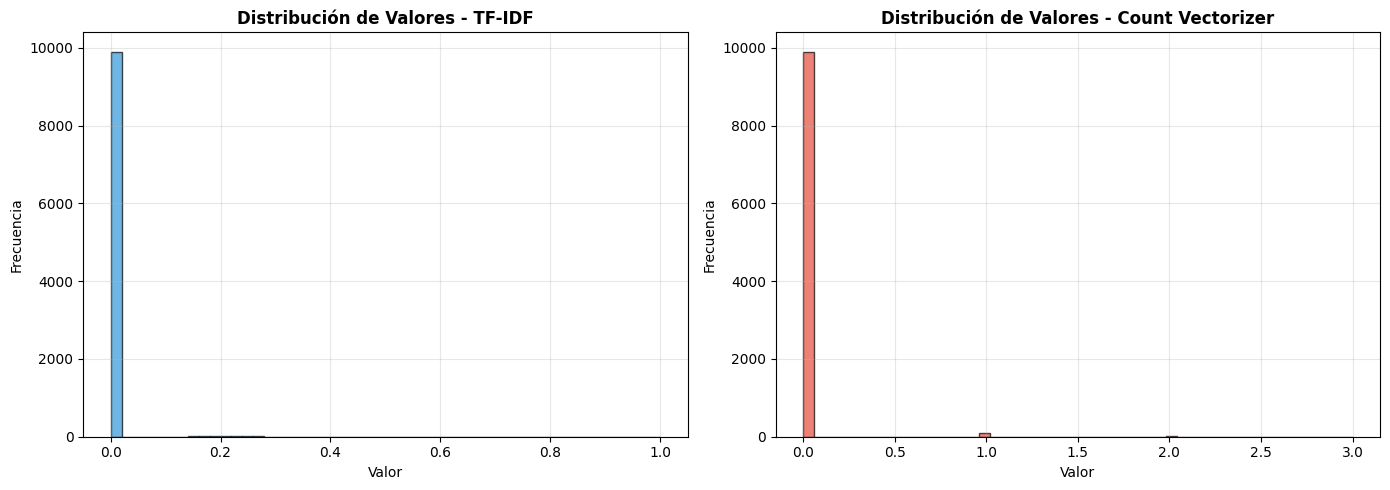

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("COMPARACIÓN DE MÉTODOS DE VECTORIZACIÓN")
print("="*80)

comparison = pd.DataFrame({
    'TF-IDF': [
        X_train_tfidf.shape[1],
        X_train_tfidf.mean(),
        X_train_tfidf.std(),
        (X_train_tfidf > 0).sum() / X_train_tfidf.size * 100,
        X_train_tfidf.max()
    ],
    'Count Vectorizer': [
        X_train_count.shape[1],
        X_train_count.mean(),
        X_train_count.std(),
        (X_train_count > 0).sum() / X_train_count.size * 100,
        X_train_count.max()
    ]
}, index=['Número de features', 'Media', 'Desviación estándar', 'Densidad (%)', 'Valor máximo'])

print("\n📊 Comparación:")
print(comparison)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de valores (muestra)
sample_tfidf = X_train_tfidf.flatten()[:10000]
sample_count = X_train_count.flatten()[:10000]

axes[0].hist(sample_tfidf, bins=50, alpha=0.7, label='TF-IDF', color='#3498db', edgecolor='black')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Valores - TF-IDF', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(sample_count, bins=50, alpha=0.7, label='Count', color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Valores - Count Vectorizer', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Guardar datos vectorizados


In [16]:
# Guardar datos vectorizados con TF-IDF
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

print("="*80)
print("GUARDANDO DATOS VECTORIZADOS")
print("="*80)

# Guardar TF-IDF
save_vectorized_data(
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test,
    output_dir,
    prefix='tfidf'
)

# Guardar Count Vectorizer
save_vectorized_data(
    X_train_count,
    X_test_count,
    y_train,
    y_test,
    output_dir,
    prefix='count'
)

print("\n✅ Todos los datos vectorizados han sido guardados")


GUARDANDO DATOS VECTORIZADOS
✅ Datos vectorizados guardados en: ../data/processed
   - tfidf_X_train.pkl
   - tfidf_X_test.pkl
   - y_train.pkl
   - y_test.pkl
✅ Datos vectorizados guardados en: ../data/processed
   - count_X_train.pkl
   - count_X_test.pkl
   - y_train.pkl
   - y_test.pkl

✅ Todos los datos vectorizados han sido guardados


## 8. Análisis de features más importantes


TOP 20 FEATURES MÁS IMPORTANTES (TF-IDF)

Feature                        Importancia    
---------------------------------------------
people                         0.036071       
black                          0.033548       
police                         0.024762       
run                            0.023469       
like                           0.023296       
shoot                          0.022175       
white                          0.021432       
cop                            0.020278       
video                          0.017761       
brown                          0.017670       
fuck                           0.017517       
good                           0.016190       
know                           0.015380       
racist                         0.015149       
think                          0.015101       
guy                            0.014149       
need                           0.014085       
right                          0.013914       
time               

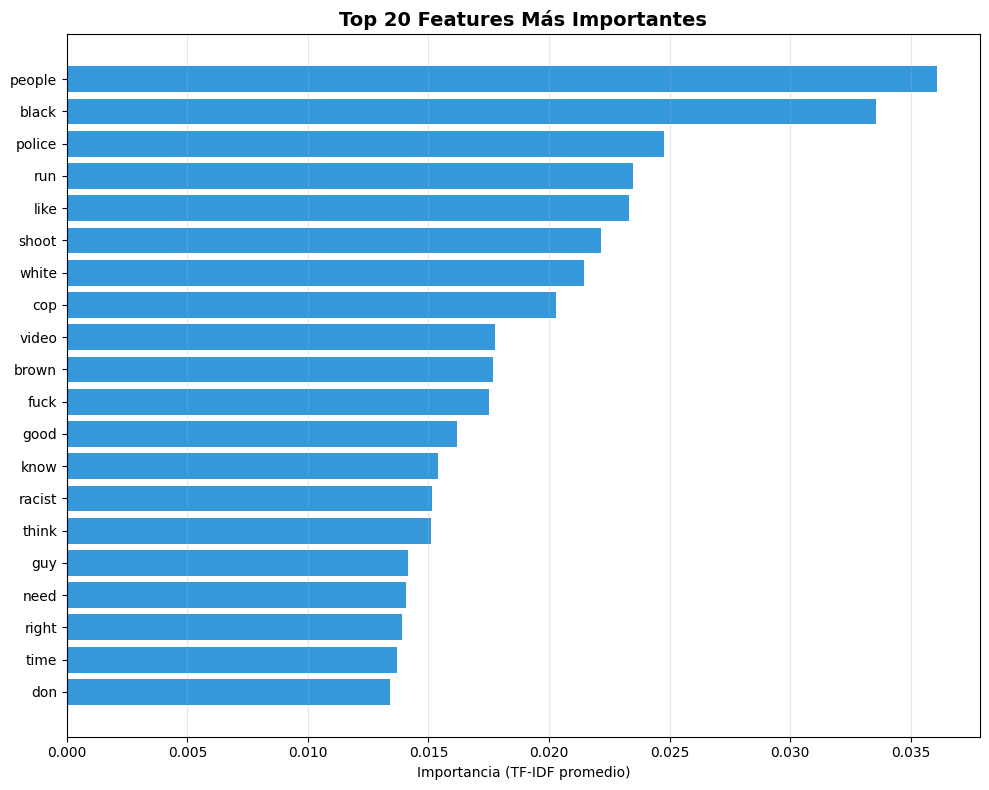

In [17]:
# Obtener features más importantes (mayor peso promedio en TF-IDF)
feature_names = vectorizer_tfidf.get_feature_names()
feature_importance = X_train_tfidf.mean(axis=0)

# Top 20 features más importantes
top_indices = np.argsort(feature_importance)[-20:][::-1]
top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]

print("="*80)
print("TOP 20 FEATURES MÁS IMPORTANTES (TF-IDF)")
print("="*80)
print(f"\n{'Feature':<30} {'Importancia':<15}")
print("-" * 45)
for feature, importance in top_features:
    print(f"{feature:<30} {importance:<15.6f}")

# Visualización
fig, ax = plt.subplots(figsize=(10, 8))
features_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])
ax.barh(range(len(features_df)), features_df['Importance'], color='#3498db')
ax.set_yticks(range(len(features_df)))
ax.set_yticklabels(features_df['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia (TF-IDF promedio)')
ax.set_title('Top 20 Features Más Importantes', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Resumen del Feature Engineering


In [18]:
print("="*80)
print("RESUMEN DEL FEATURE ENGINEERING")
print("="*80)

print(f"\n✅ Métodos implementados:")
print(f"   1. TF-IDF Vectorizer")
print(f"   2. Count Vectorizer (Bag of Words)")

print(f"\n📊 Configuración:")
print(f"   - max_features: 1000")
print(f"   - ngram_range: (1, 2) - Unigramas y bigramas")
print(f"   - min_df: 2")
print(f"   - max_df: 0.95")
print(f"   - stop_words: 'english'")

print(f"\n📈 Datos:")
print(f"   - Train: {len(X_train)} ejemplos")
print(f"   - Test: {len(X_test)} ejemplos")
print(f"   - Features TF-IDF: {X_train_tfidf.shape[1]}")
print(f"   - Features Count: {X_train_count.shape[1]}")

print(f"\n💾 Archivos guardados:")
print(f"   - ../data/processed/tfidf_X_train.pkl")
print(f"   - ../data/processed/tfidf_X_test.pkl")
print(f"   - ../data/processed/count_X_train.pkl")
print(f"   - ../data/processed/count_X_test.pkl")
print(f"   - ../data/processed/y_train.pkl")
print(f"   - ../data/processed/y_test.pkl")
print(f"   - ../models/tfidf_vectorizer.pkl")
print(f"   - ../models/count_vectorizer.pkl")

print("\n✅ Feature Engineering completado exitosamente")
print("   Listo para entrenar modelos de Machine Learning")


RESUMEN DEL FEATURE ENGINEERING

✅ Métodos implementados:
   1. TF-IDF Vectorizer
   2. Count Vectorizer (Bag of Words)

📊 Configuración:
   - max_features: 1000
   - ngram_range: (1, 2) - Unigramas y bigramas
   - min_df: 2
   - max_df: 0.95
   - stop_words: 'english'

📈 Datos:
   - Train: 800 ejemplos
   - Test: 200 ejemplos
   - Features TF-IDF: 1000
   - Features Count: 1000

💾 Archivos guardados:
   - ../data/processed/tfidf_X_train.pkl
   - ../data/processed/tfidf_X_test.pkl
   - ../data/processed/count_X_train.pkl
   - ../data/processed/count_X_test.pkl
   - ../data/processed/y_train.pkl
   - ../data/processed/y_test.pkl
   - ../models/tfidf_vectorizer.pkl
   - ../models/count_vectorizer.pkl

✅ Feature Engineering completado exitosamente
   Listo para entrenar modelos de Machine Learning
